# Introduction

We'll validate that the joint term-coordinate clustering better mitigates bias than clustering terms only.


# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities

In [2]:
vsm_version = 190428 # Version of GloVe embeddings
dtm_version = 190325 # Version of document-term matrix

## Vector space model

In [3]:
vsm = pd.read_csv("../data/text/glove_gen_n100_win15_min5_iter500_{}.txt".format(vsm_version), 
                    index_col=0, header=None, sep=" ")
print("Vocab N={}, Embedding N={}".format(vsm.shape[0], vsm.shape[1]))

Vocab N=350544, Embedding N=100


## Document-term matrix (DTM)

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=dtm_version, binarize=True)

In [5]:
lexicon = utilities.load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns).intersection(vsm.index)))
len(lexicon)

1542

In [6]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=1542


## Document splits

In [7]:
train, val = [[int(pmid.strip()) 
               for pmid in open("../data/splits/{}.txt".format(split))] 
                    for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Create a text-based ontology

## Link mental function terms

In [8]:
from ontology import ontology

In [9]:
def load_stm(X, Y):

    stm = np.dot(X.transpose(), Y)
    stm = pd.DataFrame(stm, columns=X.columns, index=Y.columns)
    stm = ontology.pmi(stm, positive=False)
    stm = stm.dropna(axis=0, how="all") # Drop terms with no co-occurrences
    stm = stm[stm.index]
    
    return stm

In [10]:
stm = load_stm(dtm_bin.loc[train], dtm_bin.loc[train])
print("Term N={}, Term N={}".format(stm.shape[0], stm.shape[1]))

Term N=1524, Term N=1524


## Cluster mental function terms

In [11]:
import os
from sklearn.cluster import KMeans

In [12]:
n_domains = range(2, 26) 

In [13]:
for k in n_domains:
    list_file = "lists/lists_k{:02d}_termclust.csv".format(k)
    if not os.path.isfile(list_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)  
        kmeans.fit(stm)
        clust = pd.DataFrame({"TOKEN": stm.index, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "TOKEN"])
        clust.to_csv(list_file, index=None)

## Compute distance of terms from centroids

In [14]:
from scipy.spatial.distance import cosine, cdist

In [15]:
columns = ["CLUSTER", "TOKEN", "DISTANCE"]

In [16]:
sims = []
for k in n_domains:
    list_file = "lists/lists_k{:02d}_termclust.csv".format(k)
    df = pd.read_csv(list_file)
    df["DISTANCE"] = 0
    for dom in range(1, k+1):
        terms = df.loc[df["CLUSTER"] == dom, "TOKEN"]
        centroid = np.mean(vsm.loc[terms]).values.reshape(1, -1)
        df.loc[df["CLUSTER"] == dom, "DISTANCE"] = cdist(vsm.loc[terms].values, centroid, "cosine")
    df = df.sort_values(["CLUSTER", "DISTANCE"])
    df["CLUSTER"] = df["CLUSTER"].astype(int)
    df = df[columns]
    df.to_csv(list_file)

## Optimize list length by semantic similarity

In [17]:
list_lens = range(5, 26)

In [18]:
for k in n_domains:
    
    ops = []
    doms = range(1, k+1)
    
    df = pd.DataFrame(index=doms, columns=list_lens)
    seed_df = pd.read_csv("lists/lists_k{:02d}_termclust.csv".format(k))
    new = pd.DataFrame(columns=columns)
    
    for dom in doms:
        seed_tkns = seed_df.loc[seed_df["CLUSTER"] == dom, "TOKEN"]
        seed_centroid = np.mean(vsm.loc[seed_tkns])
        for list_len in list_lens:
            len_tkns = seed_df.loc[seed_df["CLUSTER"] == dom, "TOKEN"][:list_len]
            len_centroid = np.mean(vsm.loc[len_tkns])
            df.loc[dom, list_len] = 1 - cosine(seed_centroid, len_centroid)
        sims = list(df.loc[dom])
        idx = sims.index(max(sims))
        op_len = np.array(list_lens)[idx]
        ops.append(op_len)
        new = new.append(seed_df.loc[seed_df["CLUSTER"] == dom][:op_len])
    df["OPTIMAL"] = ops
    df.to_csv("data/df_k{:02d}_opsim.csv".format(k))
    new = new[columns]
    new.to_csv("lists/lists_k{:02}_termclust_opsim.csv".format(k), index=None)

/anaconda3/envs/ontol/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Name the domains

In [19]:
from ontology import ontology

In [20]:
def name_domains(lists, dtm):
    
    k = len(set(lists["CLUSTER"]))
    names, degs = [""]*k, [0]*k
    terms = {i: list(set(lists.loc[lists["CLUSTER"] == i+1, "TOKEN"])) for i in range(k)}
    
    while "" in names:
        for i in range(k):
            degrees = ontology.term_degree_centrality(i+1, lists, dtm, dtm.index)
            degrees = degrees.loc[terms[i]].sort_values(ascending=False)
            name = degrees.index[0].upper()
            
            if name not in names:
                names[i] = name
                degs[i] = max(degrees)
                
            elif name in names:
                name_idx = names.index(name)
                if degs[name_idx] > degs[i]:
                    terms[i] = [term for term in terms[i] if term != name.lower()]
    return names

In [21]:
domains = {}
for k in n_domains:
    
    list_file = "lists/lists_k{:02d}_termclust_opsim.csv".format(k)
    lists = pd.read_csv(list_file, index_col=None)
    lists["TOKEN"] = lists["TOKEN"]
    if "DOMAIN" not in lists.columns:
        
        names = name_domains(lists, dtm_bin)

        lists["DOMAIN"] = [names[i-1] for i in lists["CLUSTER"]]
        lists = lists[["DOMAIN", "CLUSTER", "TOKEN", "DISTANCE"]]
        lists.to_csv(list_file, index=None)
    
    domains[k] = lists

# Plot similarity of terms to centroids

Term size scaled by semantic similarity to the centroid of terms in each domain

In [22]:
import requests
from collections import OrderedDict
from wordcloud import WordCloud
from style import style
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def plot_wordclouds(lists, vsm, path="", prefix="", colors=["gray"], 
                    font="../style/Arial Unicode.ttf", print_fig=True, height=200, width=200):

    domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))    
    for i, domain in enumerate(domains):

        def color_func(word, font_size, position, orientation, 
                       random_state=None, idx=0, **kwargs):

            # Adapted from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html

            return colors[i]

        terms = lists.loc[lists["DOMAIN"] == domain, "TOKEN"]
        centroid = np.mean(vsm.loc[terms]).values.reshape(1, -1)
        sims = 1.0 - cdist(vsm.loc[terms].values, centroid, "cosine")
        terms = [term.replace("_", " ") for term in terms]
        tkn2size = {t: s[0] for t, s in zip(terms, sims)}
        
        img = "https://www.oilshop.dk/1252-home_default/cobranol-406-polersvamp-o150mm-50mm-gra.jpg"
        mask = np.array(Image.open(requests.get(img, stream=True).raw))

        cloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGB", 
                          height=height, width=width,
                          font_path=font, mask=mask, prefer_horizontal=1,
                          random_state=42).generate_from_frequencies(frequencies=tkn2size)

        fig = plt.figure()
        plt.axis("off")
        plt.imshow(cloud.recolor(color_func=color_func, random_state=42))
        
        file_name = "{}/wordcloud_{}{}.png".format(path, prefix, domain)
        plt.savefig(file_name, dpi=300, bbox_inches="tight")
        
        if print_fig:
            print(domain)
            plt.show()
        plt.close()

## RDoC

NEGATIVE_VALENCE


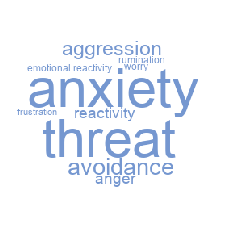

POSITIVE_VALENCE


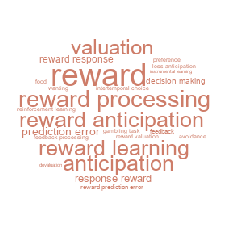

COGNITIVE_SYSTEMS


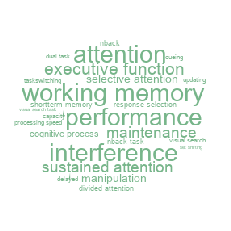

SOCIAL_PROCESSES


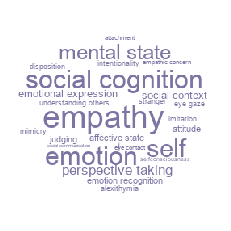

AROUSAL_REGULATION


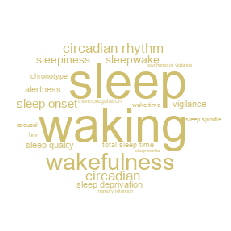

SENSORIMOTOR_SYSTEMS


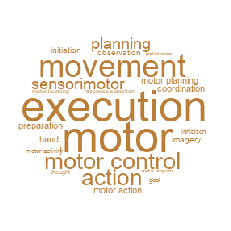

In [24]:
lists_rdoc = pd.read_csv("../ontology/lists/lists_rdoc_opsim.csv", index_col=None)
plot_wordclouds(lists_rdoc, vsm, path="figures/termclust/", prefix="rdoc_", 
                colors=style.palettes["rdoc"])

## Data-driven (terms & circuits)

MEMORY


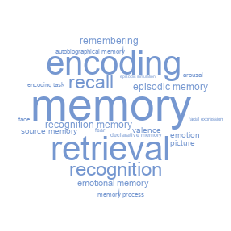

REWARD


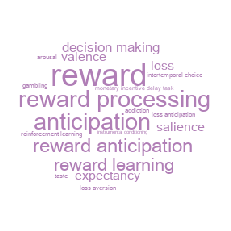

REACTION_TIME


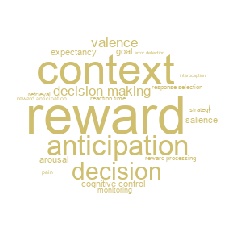

MANIPULATION


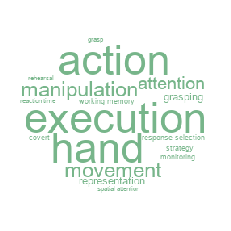

VISION


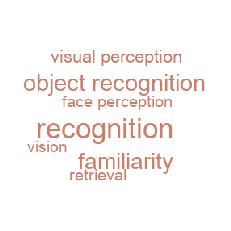

HEARING


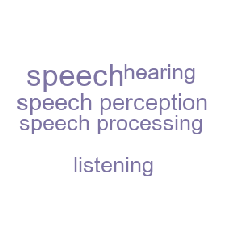

In [25]:
lists_dd = pd.read_csv("../ontology/lists/lists_data-driven_lr.csv", index_col=None)
plot_wordclouds(lists_dd, vsm, path="figures/termclust/", prefix="data-driven_",
                colors=style.palettes["data-driven"])

## Data-driven (terms only)

COGNITIVE


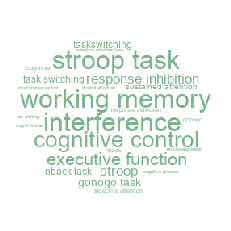

CHANGE_DETECTION_TASK


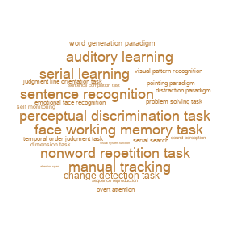

EMOTION


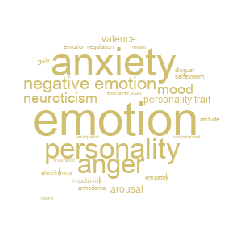

LANGUAGE


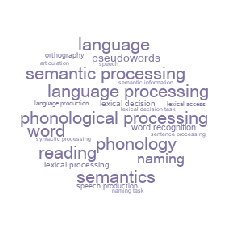

MEMORY


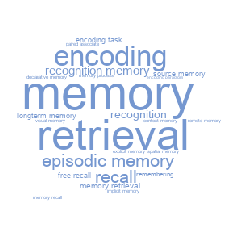

PERCEPTION


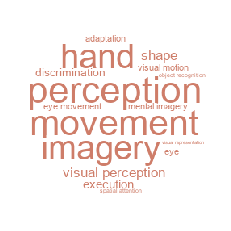

In [26]:
colors = [style.c[c] for c in ["green", "orange", "yellow", "purple", "blue", "red"]]
lists_ddt = pd.read_csv("lists/lists_k06_termclust_opsim.csv", index_col=None)
plot_wordclouds(lists_ddt, vsm, path="figures/termclust/", prefix="termclust_",
                colors=colors)

# Relate domains by similarity

In [27]:
frameworks = ["rdoc", "data-driven", "termclust"]
files = ["../ontology/lists/lists_rdoc_opsim.csv", 
         "../ontology/lists/lists_data-driven_lr.csv",
         "lists/lists_k06_termclust_opsim.csv"]

fw2terms = {fw: {} for fw in frameworks}
for i, fw in enumerate(frameworks):
    lists = pd.read_csv(files[i], index_col=None)
    domains = OrderedDict.fromkeys(lists["DOMAIN"])
    for domain in domains:
        fw2terms[fw][domain] = list(lists.loc[lists["DOMAIN"] == domain, "TOKEN"])

In [28]:
pairs = [["termclust", "data-driven"], ["termclust", "rdoc"], ["data-driven", "rdoc"]]

## Observed values

In [29]:
def compute_sim_obs(fw2terms, framework_i, framework_j, vsm):
    
    domains_i = fw2terms[framework_i].keys()
    domains_j = fw2terms[framework_j].keys()
    
    sims = np.empty((len(domains_i), len(domains_j)))
    for i, di in enumerate(domains_i):
        for j, dj in enumerate(domains_j):
            xi = np.mean(vsm.loc[fw2terms[framework_i][di]])
            xj = np.mean(vsm.loc[fw2terms[framework_j][dj]])
            sims[i,j] = 1.0 - cosine(xi, xj)
    
    sims = pd.DataFrame(sims, index=domains_i, columns=domains_j)
    return sims

In [30]:
sims = {}
for fw_i, fw_j in pairs:
    sims[fw_i + "_" + fw_j] = compute_sim_obs(fw2terms, fw_i, fw_j, vsm)

## Null distributions

In [31]:
def compute_sim_null(fw2terms, framework_i, framework_j, vsm, n_iter=10000):
    
    domains_i = fw2terms[framework_i].keys()
    domains_j = fw2terms[framework_j].keys()
    
    sims_null = np.empty((len(domains_i), len(domains_j), n_iter))
    
    for i, di in enumerate(domains_i):
        for j, dj in enumerate(domains_j):
            xi = np.mean(vsm.loc[fw2terms[framework_i][di]]).values
            xj = np.mean(vsm.loc[fw2terms[framework_j][dj]]).values
            for n in range(n_iter):
                np.random.shuffle(xi)
                np.random.shuffle(xj)
                sims_null[i,j,n] = 1.0 - cosine(xi, xj)
    
    return sims_null

In [32]:
sims_null = {}
for fw_i, fw_j in pairs:
    sims_null[fw_i + "_" + fw_j] = compute_sim_null(fw2terms, fw_i, fw_j, vsm)

## False discovery rate

In [33]:
from statsmodels.stats.multitest import multipletests

In [34]:
def compute_sim_fdr(fw2terms, framework_i, framework_j, sims, sims_null):
    
    domains_i = fw2terms[framework_i].keys()
    domains_j = fw2terms[framework_j].keys()
    
    n_iter = sims_null.shape[2]
    
    pvals = pd.DataFrame(index=domains_i, columns=domains_j)
    for i, di in enumerate(domains_i):
        for j, dj in enumerate(domains_j):
            pvals.loc[di, dj] = np.sum(sims_null[i,j,:] > sims.loc[di,dj]) / float(n_iter)
    
    fdrs = multipletests(pvals.values.ravel(), method="fdr_bh")[1]
    fdrs = np.reshape(fdrs, pvals.shape)
    fdrs = pd.DataFrame(fdrs, index=domains_i, columns=domains_j)
    return fdrs

In [35]:
sims_fdr = {}
for fw_i, fw_j in pairs:
    key = fw_i + "_" + fw_j
    sims_fdr[key] = compute_sim_fdr(fw2terms, fw_i, fw_j, sims[key], sims_null[key])

## Comparison of links

In [36]:
sims_thres = {}
for fw_i, fw_j in pairs:
    key = fw_i + "_" + fw_j
    sims_thres[key] = sims[key][sims_fdr[key] < 0.01]

## Chord diagram

In [40]:
import igraph

DeprecationWarning: To avoid name collision with the igraph project, this visualization library has been renamed to 'jgraph'. Please upgrade when convenient.